# Vertex AI GenAI Embeddings - As Features For Hierarchical Classification

**Motivation For This Workflow**

When a new product is added to inventory at a retailer it gets added to a product catalog. Correct placement in a catalog can impact which customer find or a presented with the product - ultimately impacting sales.  Building a model that can turn product descriptions (and images) into correct assignment is a product catalog can help automate product placement.

**Approaches**

A product catalog is typically 2 or more levels, a hierarchy.  A classification model for this hierarchical structure can be approached a number of ways, including:
- Leaf Node classification: build a multi-class classifier for placement into the terminal nodes of the product hierarchy.  This simplifies the problem while also loosing the information provided by the hierarchy.
- Multi-Model classification: build a multi-class classfier in any of the approaches listed here.  This is simple and retains the information in the hierarchy but has issues with managing miss-placement (errors).
    - parent node in the hierarchy
    - level of the hierarchy
    - each node (binary classifier)
- Whole space classification: a number of ways to approach this with the whole hierarchy.  The one considered in this notebook has been referred to as a Kesler's construction as presented in this [blog from Shopify](https://shopify.engineering/categorizing-products-at-scale). This approach is a balance of:
    - simplicity: reduce the whole hierarchy to a binary classifier
    - complete: uses the whole hierarchy as information
    - extendable: while the blog referenced does word tokenizaiton on a unique vocabulary, the approach used in this workflow uses a newer take by creating embeddings of product descriptions and nodes in the product catalog.

**Features? Use Embeddings!**

Embeddings are vector representations of text or images or both.  These are vectors of floating point numbers that come from a model that has been trained to embed content in a way that efficiently represents the content.

Getting embeddings for text, or multimodel text and images using Vetex AI foundational models is demonstrated in notebook [Vertex AI GenAI Embeddings](./Vertex%20AI%20GenAI%20Embeddings.ipynb).

This notebook show a use case for embeddings as features. The product hierarchy from a product catalog is represented as features by:
- embedding product descriptions
- embedding node name from the product catalog

**Highlights of This Workflow**
- Working with data in BigQuery using the BigFrames API.  Local syntax with remote (in BigQuery) execution while using a Pandas (and Scikit-Learn) like syntax.
- Serverless model training with BigQuery ML to run XGBoost
- Model Serving with SQL using BigQuery ML and BigQuery SQL.  This is especially helpful as this workflow uses a multi-pass inference approach which is orchestrated efficiently with a single SQL statement.

**Workflow:**
- Review product catalog data in BigQuery Public table: `bigquery-public-data.thelook_ecommerce.products`
- Setup BigQuery Resource Connection
    - Use ML.* to generate embeddings using Vertex AI
- Create a table with embeddings for:
    - `name` = A brief description of the product
    - `department` = The first level of the product catalog
    - `category` = The second level of the product catalog
- Prepare Data for ML
    - Create product hierarchy
    - Create test and train subsets
    - Explode test and train data by cross join with product hierarchy
        - this shapes the data for binary classification
    - Label the data: after the expansion label correct placements versus incorrect placements
- Create Models
    - Build a classifier using concatenated embeddings: product descriptions and node names
    - Build a classifier using absolute difference between embeddings: product descriptions and node names
        - magnitude of difference represents unique or similar qualities
- Model Inference

---
## Setup

In [1]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [2]:
REGION = 'us-central1'
SERIES = 'applied-genai'
EXPERIMENT = 'embed-feature-classifier'

In [3]:
# make this the BQ Project / Dataset / Table prefix to store results
BQ_PROJECT = PROJECT_ID
BQ_DATASET = SERIES.replace('-', '_')
BQ_TABLE = EXPERIMENT
BQ_REGION = REGION[0:2] # subset to first two characters for multi-region

In [190]:
import json
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import vertexai.language_models
import bigframes.pandas as bf
import bigframes.ml as bfml
from bigframes.ml import llm
from bigframes.ml import model_selection
from bigframes.ml import ensemble
from google.cloud import bigquery_connection_v1 as bq_connection
from google.cloud import bigquery

In [5]:
vertexai.init(project = PROJECT_ID, location = REGION)
bq = bigquery.Client(project = PROJECT_ID)
bf.reset_session()
bf.options.bigquery.project = BQ_PROJECT
bf.options.bigquery.location = BQ_REGION
bf_session = bf.get_global_session()

---
## Review Data Source

BigQuery Public table `bigquery-public-data.thelook_ecommerce.products`.

### Connect To Source Table: BigQuery Public Table

This is a table of products from a catelog that are arranged into `department` and further grouped into `category`.

In [6]:
products = bf.read_gbq('bigquery-public-data.thelook_ecommerce.products')

HTML(value='Query job 9a1917f0-e12a-4dd9-baf1-4a00c3c461ff is RUNNING. <a target="_blank" href="https://consol…

In [7]:
products.dtypes

id                                  Int64
cost                              Float64
category                  string[pyarrow]
name                      string[pyarrow]
brand                     string[pyarrow]
retail_price                      Float64
department                string[pyarrow]
sku                       string[pyarrow]
distribution_center_id              Int64
dtype: object

### Review `department`

In [8]:
products['department'].unique().tolist()

HTML(value='Query job 51e64e4c-8606-4308-a347-6f53badf7460 is DONE. 410.5 kB processed. <a target="_blank" hre…

['Men', 'Women']

### Review `category`

In [9]:
products['category'].unique().tolist()

HTML(value='Query job 62e2dd41-e71e-4b20-98fa-dc9e5a3cc3b5 is DONE. 594.2 kB processed. <a target="_blank" hre…

['Swim',
 'Jeans',
 'Pants',
 'Socks',
 'Active',
 'Shorts',
 'Sweaters',
 'Underwear',
 'Accessories',
 'Tops & Tees',
 'Sleep & Lounge',
 'Outerwear & Coats',
 'Suits & Sport Coats',
 'Fashion Hoodies & Sweatshirts',
 'Plus',
 'Suits',
 'Skirts',
 'Dresses',
 'Leggings',
 'Intimates',
 'Maternity',
 'Clothing Sets',
 'Pants & Capris',
 'Socks & Hosiery',
 'Blazers & Jackets',
 'Jumpsuits & Rompers']

In [10]:
products[['department', 'category']].groupby(['department', 'category']).count()

HTML(value='Query job 51afdbcc-779e-464e-aa7c-bae664bbeedf is DONE. 538.8 kB processed. <a target="_blank" hre…

HTML(value='Query job fbebb8ce-9a9b-4794-9afc-98cba6b1357b is DONE. 538.8 kB processed. <a target="_blank" hre…

HTML(value='Query job 9f70e1ad-f76a-4dbd-8ea1-cf0261664812 is DONE. 0 Bytes processed. <a target="_blank" href…

Empty DataFrame
Columns: []
Index: [(Men, Accessories), (Men, Active), (Men, Fashion Hoodies & Sweatshirts), (Men, Jeans), (Men, Outerwear & Coats), (Men, Pants), (Men, Shorts), (Men, Sleep & Lounge), (Men, Socks), (Men, Suits & Sport Coats), (Men, Sweaters), (Men, Swim), (Men, Tops & Tees), (Men, Underwear), (Women, Accessories), (Women, Active), (Women, Blazers & Jackets), (Women, Clothing Sets), (Women, Dresses), (Women, Fashion Hoodies & Sweatshirts), (Women, Intimates), (Women, Jeans), (Women, Jumpsuits & Rompers), (Women, Leggings), (Women, Maternity)]
...

[36 rows x 0 columns]

**NOTES**

There are categories that duplicate within each department: Jeans, Accessories, ...

It is probably best to accumulate the node descriptions for the hierarchy by concatenating the values for department and category to represent categories.  

In [11]:
products['category'] = products['department'] + ': ' + products['category']

In [12]:
products['category'].unique().tolist()

HTML(value='Query job c5722c49-5d7b-47a1-8425-0c87e64eae61 is RUNNING. <a target="_blank" href="https://consol…

['Men: Swim',
 'Men: Jeans',
 'Men: Pants',
 'Men: Socks',
 'Men: Active',
 'Men: Shorts',
 'Men: Sweaters',
 'Men: Underwear',
 'Men: Accessories',
 'Men: Tops & Tees',
 'Men: Sleep & Lounge',
 'Men: Outerwear & Coats',
 'Men: Suits & Sport Coats',
 'Men: Fashion Hoodies & Sweatshirts',
 'Women: Plus',
 'Women: Swim',
 'Women: Jeans',
 'Women: Suits',
 'Women: Active',
 'Women: Shorts',
 'Women: Skirts',
 'Women: Dresses',
 'Women: Leggings',
 'Women: Sweaters',
 'Women: Intimates',
 'Women: Maternity',
 'Women: Accessories',
 'Women: Tops & Tees',
 'Women: Clothing Sets',
 'Women: Pants & Capris',
 'Women: Sleep & Lounge',
 'Women: Socks & Hosiery',
 'Women: Blazers & Jackets',
 'Women: Outerwear & Coats',
 'Women: Jumpsuits & Rompers',
 'Women: Fashion Hoodies & Sweatshirts']

### Review `name`: The product description

In [13]:
products['name'].head(10)

HTML(value='Query job d31c993a-f4ec-45d9-bec2-91aa4d8db590 is DONE. 233.0 kB processed. <a target="_blank" hre…

HTML(value='Query job e63f1c61-0b0d-49ad-bc7a-4fc09c755fe4 is DONE. 1.7 MB processed. <a target="_blank" href=…

0       2XU Men's Swimmers Compression Long Sleeve Top
1           TYR Sport Men's Square Leg Short Swim Suit
2      TYR Sport Men's Solid Durafast Jammer Swim Suit
3    TYR Sport Men's Swim Short/Resistance Short Sw...
4                      TYR Alliance Team Splice Jammer
5     TYR Sport Men's 4-Inch Nylon Trainer-A Swim Suit
6               TYR Sport Men's Solid Jammer Swim Suit
7          TYR Sport Men's Poly Mesh Trainer Swim Suit
8    TYR Sport Men's Alliance Durafast Splice Squar...
9                TYR Sport Men's Solid Racer Swim Suit
Name: name, dtype: string

---
## Create BigQuery Dataset

In [14]:
# create/link to dataset
ds = bigquery.DatasetReference(BQ_PROJECT, BQ_DATASET)
ds.location = BQ_REGION
ds.labels = {'series': f'{SERIES}'}
ds = bq.create_dataset(dataset = ds, exists_ok = True) 

---
## BigQuery ML: Connect To Vertex AI LLMs with ML.GENERATE_TEXT

BigQuery ML can `Create Model`s that are actually connections to Remote Models. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model)

Using the `REMOTE_SERVICE_TYPE = "CLOUD_AI_LARGE_LANGUAGE_MODEL_V1"` option will link to LLMs in Vertex AI!

### Connection Requirement

To make a remote connection using BigQuery ML, BigQuery uses a CLOUD_RESOURCE connection. [Reference](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-remote-model#connection)

Make sure the [BigQuery Connection API](https://cloud.google.com/bigquery/docs/create-cloud-resource-connection) is enabled:

In [15]:
!gcloud services enable bigqueryconnection.googleapis.com

Create a new connection with type `CLOUD_RESOURCE`: First, check for existing connection.

In [16]:
try:
    response = bq_connection.ConnectionServiceClient().get_connection(
            request = bq_connection.GetConnectionRequest(
                name = f"projects/{BQ_PROJECT}/locations/{BQ_REGION}/connections/{SERIES}_{EXPERIMENT}"
            )
    )
    print(f'Found existing connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id
except Exception:
    request = bq_connection.CreateConnectionRequest(
        {
            "parent": f"projects/{BQ_PROJECT}/locations/{BQ_REGION}",
            "connection_id": f"{SERIES}_{EXPERIMENT}",
            "connection": bq_connection.types.Connection(
                {
                    "friendly_name": f"{SERIES}_{EXPERIMENT}",
                    "cloud_resource": bq_connection.CloudResourceProperties({})
                }
            )
        }
    )
    response = bq_connection.ConnectionServiceClient().create_connection(request)
    print(f'Created new connection with service account: {response.cloud_resource.service_account_id}')
    service_account = response.cloud_resource.service_account_id
    # assign the service account the Vertex AI User Role:
    !gcloud projects add-iam-policy-binding {BQ_PROJECT} --member=serviceAccount:{service_account} --role=roles/aiplatform.user

Found existing connection with service account: bqcx-1026793852137-pdxa@gcp-sa-bigquery-condel.iam.gserviceaccount.com


**NOTE**: The step above created a service account and assigned it the Vertex AI User Role.  This may take a moment to be recognized in the steps below.  If you get an error in one of the cells below try rerunning it.

### Create The Remote Model In BigQuery

Create a temp model that connects to text embedding model on Vertex AI - [Reference](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.llm.PaLM2TextEmbeddingGenerator)

In [17]:
embed_model = bfml.llm.PaLM2TextEmbeddingGenerator(
    session = bf_session,
    connection_name = f'{BQ_PROJECT}.{BQ_REGION}.{SERIES}_{EXPERIMENT}'
)

HTML(value='Query job 69b9018d-33a9-44c6-9c33-092d99762362 is RUNNING. <a target="_blank" href="https://consol…

---
## Create Embeddings

### For Product Descriptions: Name

**NOTE**: The following cell will create embedding requests for all 29k+ values in the `name` column and could take around **10 minutes** to run.

In [18]:
products = products.join(embed_model.predict(products['name']).rename(columns={'text_embedding':'name_embedding'}))

HTML(value='Query job 5198d374-1a18-4ba2-a9b3-fb884752b3fd is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 8710953e-d880-4fed-b50c-f12b8e27d9bf is DONE. 233.0 kB processed. <a target="_blank" hre…

In [19]:
products.head()

HTML(value='Query job 987c64d1-e59a-49cf-9c88-45c62ce354e2 is DONE. 465.9 kB processed. <a target="_blank" hre…

HTML(value='Query job 4ba3effa-b875-4720-b2fa-7c3ea5017302 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 53da9618-5b5e-4e9f-9e55-17fb557a13fa is DONE. 0 Bytes processed. <a target="_blank" href…

,id,cost,category,name,brand,retail_price,department,sku,distribution_center_id,name_embedding
0,27569,92.652563,Men: Swim,2XU Men's Swimmers Compression Long Sleeve Top,2XU,150.410004,Men,B23C5765E165D83AA924FA8F13C05F25,1,"[0.021811574697494507, -0.0068705384619534016,..."
1,27445,24.719661,Men: Swim,TYR Sport Men's Square Leg Short Swim Suit,TYR,38.990002,Men,2AB7D3B23574C3DEA2BD278AFD0939AB,1,"[0.04419781640172005, -0.009351101703941822, 0..."
2,27457,15.8976,Men: Swim,TYR Sport Men's Solid Durafast Jammer Swim Suit,TYR,27.6,Men,8F831227B0EB6C6D09A0555531365933,1,"[0.0471641980111599, -0.03273119032382965, 0.0..."
3,27466,17.85,Men: Swim,TYR Sport Men's Swim Short/Resistance Short Sw...,TYR,30.0,Men,67317D6DCC4CB778AEB9219565F5456B,1,"[0.049136240035295486, 0.0037870346568524837, ..."
4,27481,29.408001,Men: Swim,TYR Alliance Team Splice Jammer,TYR,45.950001,Men,213C888198806EF1A0E2BBF2F4855C6C,1,"[0.0008693744894117117, -0.00447087874636054, ..."


### For Level 1 of Product Hierarchy: Department

This step will run quickly as it only creates embedding request for unique values of `department`.

In [20]:
department = products['department'].unique().to_frame()
department = department.join(embed_model.predict(department).rename(columns={'text_embedding':'department_embedding'}))

HTML(value='Query job 29419c8d-d599-4ee8-9648-23b61b4b3c5f is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job ebeeefaa-539c-4f4a-8c61-2c5655da6c11 is DONE. 16 Bytes processed. <a target="_blank" hre…

In [21]:
department.head()

HTML(value='Query job 10a245d0-8b81-4d64-a072-f13e0f068147 is DONE. 643.5 kB processed. <a target="_blank" hre…

HTML(value='Query job df51b3dd-dc91-45b7-bf89-878024287425 is DONE. 655.8 kB processed. <a target="_blank" hre…

HTML(value='Query job 58424e6d-a888-497f-a405-fec4cc8ad686 is DONE. 0 Bytes processed. <a target="_blank" href…

,department,department_embedding
0,Men,"[-0.04335380345582962, 0.00046764410217292607,..."
13131,Women,"[-0.03191345930099487, -0.006457726005464792, ..."


In [22]:
products = products.merge(department, on = 'department')
products.dtypes

id                                  Int64
cost                              Float64
category                  string[pyarrow]
name                      string[pyarrow]
brand                     string[pyarrow]
retail_price                      Float64
department                string[pyarrow]
sku                       string[pyarrow]
distribution_center_id              Int64
name_embedding                     object
department_embedding               object
dtype: object

### For Level 2 of Product Hierarchy: Category

This step will run quickly as it only creates embedding request for unique values of `category`.

In [23]:
category = products['category'].unique().to_frame()
category = category.join(embed_model.predict(category).rename(columns={'text_embedding':'category_embedding'}))

HTML(value='Query job 63b3f590-164e-4d25-bbb1-fd11b8469949 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 2de1e807-a067-4339-9db1-a83cc3bee9ac is DONE. 288 Bytes processed. <a target="_blank" hr…

In [24]:
category.head()

HTML(value='Query job a588b4c3-2dbe-4a4e-ba7b-a3653c9a7f0b is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job aaabd852-4cea-45bc-a216-245c10de7296 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 5ccfd30f-81bc-4910-a8a7-a86ac0d6e541 is DONE. 0 Bytes processed. <a target="_blank" href…

,category,category_embedding
0,Men: Swim,"[0.024325380101799965, 0.0083873076364398, 0.0..."
906,Men: Jeans,"[-0.033402811735868454, 0.007221992593258619, ..."
2023,Men: Pants,"[-0.019241666421294212, 0.023088112473487854, ..."
3064,Men: Socks,"[0.03812064602971077, 0.02077236771583557, 0.0..."
3969,Men: Active,"[0.026801789179444313, 5.999019049340859e-05, ..."


In [25]:
products = products.merge(category, on = 'category')
products.dtypes

id                                  Int64
cost                              Float64
category                  string[pyarrow]
name                      string[pyarrow]
brand                     string[pyarrow]
retail_price                      Float64
department                string[pyarrow]
sku                       string[pyarrow]
distribution_center_id              Int64
name_embedding                     object
department_embedding               object
category_embedding                 object
dtype: object

### Make BigQuery Tables of Results

The `products`, `department`, and `category` dataframes are currently temporary tables in BigQuery.  To recall these for future use it is best to store them as actual BigQuery tables using the [.to_gbq](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.dataframe.DataFrame#bigframes_dataframe_DataFrame_to_gbq) method as follows.

In [26]:
products.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_products', if_exists = 'replace', index = False)
department.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_deparment', if_exists = 'replace', index = False)
category.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_category', if_exists = 'replace', index = False)

HTML(value='Query job 5ab72764-1429-4958-a016-2be2b5f63841 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job ff55b4e5-9fcf-40bf-8136-c8f3c6154b81 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 3baaeccd-9b71-40d2-9cc2-5171b2047e41 is RUNNING. <a target="_blank" href="https://consol…

---
## Prepare Data For ML

### Create product hierarchy set: department

In [27]:
department.dtypes

department              string[pyarrow]
department_embedding             object
dtype: object

In [28]:
department_hierarchy = department[['department', 'department_embedding']].rename(columns = {"department":"hierarchy_node", "department_embedding":"hierarchy_node_embedding"})
department_hierarchy['hierarchy_level'] = 'department'
department_hierarchy['hierarchy_node_parent'] = 'ALL'
department_hierarchy.dtypes

hierarchy_node              string[pyarrow]
hierarchy_node_embedding             object
hierarchy_level             string[pyarrow]
hierarchy_node_parent       string[pyarrow]
dtype: object

In [29]:
department_hierarchy.head()

HTML(value='Query job 72c2e499-ae3f-4e0f-b4a5-45c51641d729 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job cf9bd941-765f-4029-a0d0-654d495f6009 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 62d81626-fe4d-4c76-8fc8-06dbd755d293 is DONE. 0 Bytes processed. <a target="_blank" href…

,hierarchy_node,hierarchy_node_embedding,hierarchy_level,hierarchy_node_parent
0,Men,"[-0.04335380345582962, 0.00046764410217292607,...",department,ALL
13131,Women,"[-0.03191345930099487, -0.006457726005464792, ...",department,ALL


### Create product hierarchy set: category

In [64]:
category.dtypes

category              string[pyarrow]
category_embedding             object
dtype: object

In [65]:
category_hierarchy = category[['category', 'category_embedding']].rename(
    columns = {
        "category":"hierarchy_node", 
        "category_embedding":"hierarchy_node_embedding"
    }
)
category_hierarchy['hierarchy_level'] = 'category'
category_hierarchy.dtypes

hierarchy_node              string[pyarrow]
hierarchy_node_embedding             object
hierarchy_level             string[pyarrow]
dtype: object

In [66]:
category_hierarchy.shape

HTML(value='Query job a7e2b481-7536-4f4e-816c-2e5f32e35eda is RUNNING. <a target="_blank" href="https://consol…

(36, 3)

In [67]:
category_hierarchy = category_hierarchy.merge(
    products[['department', 'category']].drop_duplicates(),
    how = 'left',
    left_on = 'hierarchy_node',
    right_on = 'category').rename(
        columns = {
            "department":"hierarchy_node_parent"
        }
    ).drop(['category'], axis = 1)

In [68]:
category_hierarchy.shape

HTML(value='Query job 79921408-4669-4bd4-9f3a-fd9514dff38d is RUNNING. <a target="_blank" href="https://consol…

(36, 4)

In [69]:
category_hierarchy

HTML(value='Query job 48112b07-02f6-4339-9a5d-a0fdfa8fbb34 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job a402987b-6331-4e7f-9fe0-e3224cc22681 is DONE. 0 Bytes processed. <a target="_blank" href…

,hierarchy_node,hierarchy_node_embedding,hierarchy_level,hierarchy_node_parent
0,Men: Swim,"[0.024325380101799965, 0.0083873076364398, 0.0...",category,Men
1,Men: Jeans,"[-0.033402811735868454, 0.007221992593258619, ...",category,Men
2,Men: Pants,"[-0.019241666421294212, 0.023088112473487854, ...",category,Men
3,Men: Socks,"[0.03812064602971077, 0.02077236771583557, 0.0...",category,Men
4,Men: Active,"[0.026801789179444313, 5.999019049340859e-05, ...",category,Men
5,Men: Shorts,"[-0.0018635086016729474, 0.030349334701895714,...",category,Men
6,Men: Sweaters,"[-0.0014772552531212568, 0.009987411089241505,...",category,Men
7,Men: Underwear,"[-0.008752256631851196, 0.02730068750679493, 0...",category,Men
8,Men: Accessories,"[0.008520721457898617, 0.008341425098478794, 0...",category,Men
9,Men: Tops & Tees,"[0.012527522630989552, 0.0038282929453998804, ...",category,Men


### Create product hierarchy: combine department and category

In [70]:
product_hierarchy = bf.concat([department_hierarchy, category_hierarchy])

In [71]:
product_hierarchy.head()

HTML(value='Query job c2f04b63-69e2-4a4e-9063-4db99edfcbb1 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 59238b4b-2bd2-40fe-a5de-a33f296a187a is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 45bee92d-f70c-4e9e-8875-8937273200b5 is DONE. 0 Bytes processed. <a target="_blank" href…

,hierarchy_node,hierarchy_node_embedding,hierarchy_level,hierarchy_node_parent
0,Men,"[-0.04335380345582962, 0.00046764410217292607,...",department,ALL
13131,Women,"[-0.03191345930099487, -0.006457726005464792, ...",department,ALL
0,Men: Swim,"[0.024325380101799965, 0.0083873076364398, 0.0...",category,Men
1,Men: Jeans,"[-0.033402811735868454, 0.007221992593258619, ...",category,Men
2,Men: Pants,"[-0.019241666421294212, 0.023088112473487854, ...",category,Men


### Create test and train subsets of products

Create index's for rows allocated to training and test splits:

In [72]:
# retrieve index of all rows
full_index = products.index.to_numpy()
# randomly sort the full index
np.random.shuffle(full_index)
# split the randomly sorted index into 10 sequential parts
split_index = np.split(full_index, 10)
# allocate the first 9 splits (90%) to a training index
train_index = np.concatenate(split_index[0:9])
# allocate the last split (10%) to a test_index
test_index = split_index[9]

# print out the sizes of the indexes:
full_index.shape[0], train_index.shape[0], test_index.shape[0]

HTML(value='Query job 21de99cf-7d06-4c9d-bfde-18c342528481 is RUNNING. <a target="_blank" href="https://consol…

(29120, 26208, 2912)

In [73]:
train_products = products[['id', 'name', 'name_embedding', 'category', 'department']].iloc[train_index.tolist()]
test_products = products[['id', 'name', 'name_embedding', 'category', 'department']].iloc[test_index.tolist()]

HTML(value='Load job 76043efa-87e8-4a57-b73e-23ba5a7b0e3d is RUNNING. <a target="_blank" href="https://console…

HTML(value='Load job 5f9b44aa-38d8-4d8e-887f-239881d0d997 is RUNNING. <a target="_blank" href="https://console…

### Create Training And Test Data: Explode product data by crossing with product hierarchy

In [74]:
train_products = train_products.merge(product_hierarchy, how = 'cross')

ValueError: Must specify `on` or `left_on` + `right_on`.

**NOTE**: The cross join does not seem to be available yet on the BigFrames API ([Reference](https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.pandas#bigframes_pandas_merge)).  To work around this adding a dummy column to both tables to do an inner join on.

In [75]:
train_products['dummy'] = 1
test_products['dummy'] = 1
product_hierarchy['dummy'] = 1

In [76]:
train_products = train_products.merge(product_hierarchy, how = 'inner', on = 'dummy').drop('dummy', axis = 1)
test_products = test_products.merge(product_hierarchy, how = 'inner', on = 'dummy').drop('dummy', axis = 1)
product_hiearchy = product_hierarchy.drop('dummy', axis = 1)

### Add Label To Training Training And Test Data

In [78]:
train_products_yes = train_products[((train_products['category'] == train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'category')) | ((train_products['department'] == train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'department'))]
train_products_yes['label'] = 1
train_products_no = train_products[((train_products['category'] != train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'category')) | ((train_products['department'] != train_products['hierarchy_node']) & (train_products['hierarchy_level'] == 'department'))]
train_products_no['label'] = 0

train_products = bf.concat([train_products_yes, train_products_no])

In [79]:
test_products_yes = test_products[((test_products['category'] == test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'category')) | ((test_products['department'] == test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'department'))]
test_products_yes['label'] = 1
test_products_no = test_products[((test_products['category'] != test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'category')) | ((test_products['department'] != test_products['hierarchy_node']) & (test_products['hierarchy_level'] == 'department'))]
test_products_no['label'] = 0

test_products = bf.concat([test_products_yes, test_products_no])

Make BigQuery tables from the temporary tables:

In [80]:
train_products.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_train_products', if_exists = 'replace', index = False)
test_products.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_products', if_exists = 'replace', index = False)

HTML(value='Query job 278e3c54-87c2-4966-8d04-d0d0aaca2b25 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job e3e7a752-c2cf-432c-a675-dd7a5614f0f1 is RUNNING. <a target="_blank" href="https://consol…

---
## Create Models

Build a classifier model from:
- the combination of embedding vectors from the product name (`name`) and the node name from the product hierarchy
- the absolute difference between the two embedding vectors repesenting the product and the node in the product hierarchy

### Prepare Train and Test For Model Input

In [81]:
features = ''
for i in range(768):
    features += f""",
    name_embedding[{i}] as name_{i}, hierarchy_node_embedding[{i}] as hier_{i}, ABS(name_embedding[{i}] - hierarchy_node_embedding[{i}]) as adiff_{i} """

test_input_query = f"""
SELECT * {features}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_products`
WHERE name is not null AND hierarchy_node is not null
"""

train_input_query = f"""
SELECT * {features}
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_train_products`
WHERE name is not null
    AND ARRAY_LENGTH(name_embedding) > 0
    AND ARRAY_LENGTH(hierarchy_node_embedding) > 0
"""

In [82]:
#print(test_input)

In [83]:
test_input = bf.read_gbq(test_input_query)

HTML(value='Query job 7635b2ea-2c4a-453b-8583-e2dc7ba55484 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 29a0d49d-673e-4f7d-91df-3240794954b3 is RUNNING. <a target="_blank" href="https://consol…

In [84]:
test_input.shape

HTML(value='Query job 5a8c7eec-e020-4d95-98a0-d060be92c6a3 is DONE. 0 Bytes processed. <a target="_blank" href…

(110656, 2314)

In [85]:
train_input = bf.read_gbq(train_input_query)

HTML(value='Query job e2302599-d294-42f5-8984-374dedc181a8 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job f462956d-3979-487c-a461-fc657cd9907a is RUNNING. <a target="_blank" href="https://consol…

In [86]:
train_input.shape

HTML(value='Query job 22851914-e112-4934-b05b-f5b3439d3cf8 is DONE. 0 Bytes processed. <a target="_blank" href…

(995828, 2314)

In [87]:
train_input.dtypes

id                          Int64
name              string[pyarrow]
name_embedding             object
category          string[pyarrow]
department        string[pyarrow]
                       ...       
hier_766                  Float64
adiff_766                 Float64
name_767                  Float64
hier_767                  Float64
adiff_767                 Float64
Length: 2314, dtype: object

### Train Classifier: Concatenate Embeddings as Features

In [88]:
classifier_model = bfml.ensemble.XGBClassifier()

In [89]:
features = [col for col in train_input.columns if (col.startswith('name_') or col.startswith('hier_')) and col != 'name_embedding']

In [90]:
classifier_model.fit(X = train_input[features], y = train_input['label'])

HTML(value='Query job 409679dd-2009-4098-9ab9-79c1d36cd5a5 is RUNNING. <a target="_blank" href="https://consol…

XGBClassifier()

In [91]:
classifier_model.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier', replace = True)

HTML(value='Copy job 11f9eed8-5086-4040-9b69-05c2b2a1fa7d is RUNNING. <a target="_blank" href="https://console…

XGBClassifier(booster='GBTREE', tree_method='AUTO')

In [92]:
classifier_model.get_params()

{'booster': 'gbtree',
 'colsample_bylevel': 1.0,
 'colsample_bynode': 1.0,
 'colsample_bytree': 1.0,
 'dart_normalized_type': 'TREE',
 'early_stop': True,
 'enable_global_explain': False,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 6,
 'max_iterations': 20,
 'min_rel_progress': 0.01,
 'min_tree_child_weight': 1,
 'num_parallel_tree': 1,
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'subsample': 1.0,
 'tree_method': 'auto',
 'xgboost_version': '0.9'}

In [93]:
classifier_model.predict(X = test_input.head())

HTML(value='Query job 2517b7a9-3d81-44d1-b762-5de5c2de6f9a is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job f1e5cb05-17bb-40a0-b56f-133659ddacc4 is DONE. 40 Bytes processed. <a target="_blank" hre…

HTML(value='Query job 62000e36-0442-4653-bb42-3c316b04af2a is DONE. 0 Bytes processed. <a target="_blank" href…

HTML(value='Query job 5975145b-9464-468b-8e05-349036bc41dc is DONE. 80 Bytes processed. <a target="_blank" hre…

HTML(value='Query job 43856364-cdd0-4e4e-abe1-cc0078f3a875 is DONE. 0 Bytes processed. <a target="_blank" href…

,predicted_label
0,0
1,0
2,0
3,0
4,0


### Train Classifier: Absolute Difference Between Embeddings as Features

In [94]:
classifier_model_adiff = bfml.ensemble.XGBClassifier()

In [95]:
features = [col for col in train_input.columns if col.startswith('adiff_')]

In [96]:
classifier_model_adiff.fit(X = train_input[features], y = train_input['label'])

HTML(value='Query job f5a35466-1668-433b-bc5e-b90e0eacea9c is RUNNING. <a target="_blank" href="https://consol…

XGBClassifier()

In [97]:
classifier_model_adiff.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier_adiff', replace = True)

HTML(value='Copy job b7b69967-3a20-408e-bd5f-2a92cb238848 is RUNNING. <a target="_blank" href="https://console…

XGBClassifier(booster='GBTREE', tree_method='AUTO')

In [98]:
classifier_model_adiff.get_params()

{'booster': 'gbtree',
 'colsample_bylevel': 1.0,
 'colsample_bynode': 1.0,
 'colsample_bytree': 1.0,
 'dart_normalized_type': 'TREE',
 'early_stop': True,
 'enable_global_explain': False,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 6,
 'max_iterations': 20,
 'min_rel_progress': 0.01,
 'min_tree_child_weight': 1,
 'num_parallel_tree': 1,
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'subsample': 1.0,
 'tree_method': 'auto',
 'xgboost_version': '0.9'}

In [99]:
classifier_model_adiff.predict(X = test_input.head())

HTML(value='Query job 0bb668b6-e94f-4ff6-836b-47a57799dca4 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 6bc636af-082b-48d5-af8d-dffe0d9b69ed is DONE. 40 Bytes processed. <a target="_blank" hre…

HTML(value='Query job d89eb8c0-f5bc-4401-8a64-1431746434f9 is DONE. 0 Bytes processed. <a target="_blank" href…

HTML(value='Query job 9fcfb77c-8671-47b6-9db7-2d307c38b5f1 is DONE. 80 Bytes processed. <a target="_blank" hre…

HTML(value='Query job 27bfa260-b1ba-4f61-b7d8-3e95ea00fe17 is DONE. 0 Bytes processed. <a target="_blank" href…

,predicted_label
0,0
1,0
2,0
3,0
4,0


### Train Classifier: Concatenated Embedding AND Absolute Difference Between Embeddings as Features

In [255]:
classifier_model_conadiff = bfml.ensemble.XGBClassifier(max_depth = 15, max_iterations = 50)

In [256]:
features = [col for col in train_input.columns if (col.startswith('adiff_') or col.startswith('name_') or col.startswith('hier_')) and col != 'name_embedding']

In [ ]:
classifier_model_conadiff.fit(X = train_input[features], y = train_input['label'])

HTML(value='Query job 8c1f93ce-8dd4-44a5-befb-30628a5692f0 is RUNNING. <a target="_blank" href="https://consol…

In [261]:
classifier_model_conadiff.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_classifier_conadiff', replace = True)

HTML(value='Copy job b3daf4e8-8cbe-482d-acef-3d2795b35a9a is RUNNING. <a target="_blank" href="https://console…

XGBClassifier(booster='GBTREE', max_depth=15, max_iterations=50,
              tree_method='AUTO')

In [262]:
classifier_model_conadiff.get_params()

{'booster': 'gbtree',
 'colsample_bylevel': 1.0,
 'colsample_bynode': 1.0,
 'colsample_bytree': 1.0,
 'dart_normalized_type': 'TREE',
 'early_stop': True,
 'enable_global_explain': False,
 'gamma': 0.0,
 'learning_rate': 0.3,
 'max_depth': 15,
 'max_iterations': 50,
 'min_rel_progress': 0.01,
 'min_tree_child_weight': 1,
 'num_parallel_tree': 1,
 'reg_alpha': 0.0,
 'reg_lambda': 1.0,
 'subsample': 1.0,
 'tree_method': 'auto',
 'xgboost_version': '0.9'}

In [263]:
classifier_model_conadiff.predict(X = test_input.head())

HTML(value='Query job 1726f587-c50a-4b61-b112-b11177844554 is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 5bf0091e-0900-4305-b2a9-2026b63745e9 is DONE. 40 Bytes processed. <a target="_blank" hre…

HTML(value='Query job e22bf11f-44e9-49ac-a1ae-858e8aa27260 is DONE. 0 Bytes processed. <a target="_blank" href…

HTML(value='Query job 021ede12-1238-4b20-ac53-3068576f4772 is DONE. 80 Bytes processed. <a target="_blank" hre…

HTML(value='Query job 7a998f82-4c69-47f6-a2ef-a3347ea5f8cc is DONE. 0 Bytes processed. <a target="_blank" href…

,predicted_label
0,0
1,0
2,0
3,0
4,0


---
---
---
# NOTE: Switching To BigQuery API
    
Working with the model in BigQuery ML requires some features that are not yet in the BigFrames API.  The following section switches to the BigQuery API and uses SQL to retrive results to local Pandas dataframes.

**EXAMPLE**

In the section above the `.predict()` method was used to retrive predictions.  The only column returned is the predicted label.  For this project the probability for each class label is needed to infer the right placement in the product hierarchy.

In [100]:
# save model input to BigQuery Tables
train_input.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_train_input', if_exists = 'replace', index = False)
test_input.to_gbq(f'{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input', if_exists = 'replace', index = False)

HTML(value='Query job de2b3f08-26a2-47f2-bf54-e856f947afdd is RUNNING. <a target="_blank" href="https://consol…

HTML(value='Query job 9532a7b9-7107-4852-a9d7-2377128308bc is RUNNING. <a target="_blank" href="https://consol…

---
## Model Inference: Develop Approach With 1 Instance

Request predictions.  With this data shape the process is iterative.

In [132]:
LIMITER = 'LIMIT 1' # level blank for all
MODEL_NAME = 'classifier' # specify model name between classifier and classifier_adiff

query = f"""
SELECT *
FROM ML.PREDICT (
    MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
    (
        SELECT *
        FROM (SELECT id FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input` {LIMITER})
        LEFT OUTER JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input`
        USING(id)
    )
)
"""

In [133]:
pred = bq.query(query = query).to_dataframe()

In [135]:
pred.shape

(38, 2316)

In [134]:
pred.head()

,predicted_label,predicted_label_probs,id,name,name_embedding,category,department,hierarchy_node,hierarchy_node_embedding,hierarchy_level,...,adiff_764,name_765,hier_765,adiff_765,name_766,hier_766,adiff_766,name_767,hier_767,adiff_767
0,0,"[{'label': 1, 'prob': 0.0035299051087349653}, ...",5774,Lysse leggings for women - Stretch Velvet Wide...,"[-0.021069515496492386, -0.004133570473641157,...",Women: Leggings,Women,Women: Jumpsuits & Rompers,"[0.0405508428812027, -0.020176339894533157, 0....",category,...,0.040149,-0.019151,0.008277,0.027427,-0.01367,-0.001506,0.012164,0.002335,-0.007692,0.010026
1,0,"[{'label': 1, 'prob': 0.011903602629899979}, {...",5774,Lysse leggings for women - Stretch Velvet Wide...,"[-0.021069515496492386, -0.004133570473641157,...",Women: Leggings,Women,Men,"[-0.04335380345582962, 0.00046764410217292607,...",department,...,0.008727,-0.019151,0.007084,0.026235,-0.01367,-0.033502,0.019832,0.002335,-0.034115,0.036450
2,0,"[{'label': 1, 'prob': 0.00996493361890316}, {'...",5774,Lysse leggings for women - Stretch Velvet Wide...,"[-0.021069515496492386, -0.004133570473641157,...",Women: Leggings,Women,Women: Shorts,"[0.015928752720355988, 0.02097945660352707, 0....",category,...,0.017678,-0.019151,-0.008283,0.010868,-0.01367,-0.010817,0.002853,0.002335,-0.021802,0.024137
3,0,"[{'label': 1, 'prob': 0.008111339993774891}, {...",5774,Lysse leggings for women - Stretch Velvet Wide...,"[-0.021069515496492386, -0.004133570473641157,...",Women: Leggings,Women,Men: Sweaters,"[-0.0014772552531212568, 0.009987411089241505,...",category,...,0.027711,-0.019151,0.009705,0.028855,-0.01367,-0.011609,0.002061,0.002335,-0.020680,0.023015
4,0,"[{'label': 1, 'prob': 0.16571517288684845}, {'...",5774,Lysse leggings for women - Stretch Velvet Wide...,"[-0.021069515496492386, -0.004133570473641157,...",Women: Leggings,Women,Women: Leggings,"[-0.01884756051003933, -0.01592167839407921, 0...",category,...,0.017813,-0.019151,0.016676,0.035827,-0.01367,-0.040228,0.026558,0.002335,0.015191,0.012857


**Note**

Each product has two nodes they are placed in within the hierarchy: department and category withing department.  The predictions are presented for all possible nodes of the hierarchy.  The next step is to reduce the columns returned and expand the predicted_label_probs and present the predicted probability for label = 1.

In [159]:
LIMITER = 'LIMIT 1' # level blank for all
MODEL_NAME = 'classifier' # specify model name between classifier and classifier_adiff

query = f"""
SELECT *
FROM (
    SELECT id, predicted_label_probs, label, name, category, department, hierarchy_level, hierarchy_node, hierarchy_node_parent
    FROM ML.PREDICT (
        MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
        (
            WITH limiter AS (SELECT id FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input` {LIMITER})
            SELECT *
            FROM limiter
            LEFT OUTER JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input`
            USING(id)
        )
    )
) p
CROSS JOIN UNNEST(p.predicted_label_probs) as probs
WHERE probs.label = 1
"""

In [160]:
pred = bq.query(query = query).to_dataframe()

In [161]:
pred.shape

(38, 11)

In [162]:
pred.head()

,id,predicted_label_probs,label,name,category,department,hierarchy_level,hierarchy_node,hierarchy_node_parent,label_1,prob
0,3008,"[{'label': 1, 'prob': 0.010954124853014946}, {...",0,Hot Chillys Women's Micro-Elite Chamois 8K Sol...,Women: Active,Women,category,Men: Suits & Sport Coats,Men,1,0.010954
1,3008,"[{'label': 1, 'prob': 0.0200710017234087}, {'l...",0,Hot Chillys Women's Micro-Elite Chamois 8K Sol...,Women: Active,Women,category,Men: Pants,Men,1,0.020071
2,3008,"[{'label': 1, 'prob': 0.040706321597099304}, {...",0,Hot Chillys Women's Micro-Elite Chamois 8K Sol...,Women: Active,Women,category,Men: Underwear,Men,1,0.040706
3,3008,"[{'label': 1, 'prob': 0.005649976897984743}, {...",0,Hot Chillys Women's Micro-Elite Chamois 8K Sol...,Women: Active,Women,category,Women: Skirts,Women,1,0.005650
4,3008,"[{'label': 1, 'prob': 0.024597570300102234}, {...",0,Hot Chillys Women's Micro-Elite Chamois 8K Sol...,Women: Active,Women,category,Men: Fashion Hoodies & Sweatshirts,Men,1,0.024598


**Note**

For the each id value, what is the predicted placement in the hierarchy?

This requires making inference down the structure of the hierarchy:
- what is highest predicted probability for `department`?
- what is highest predicted probability for `category` within the selected `department`?
- Is the answer right or wrong?

In [167]:
LIMITER = 'LIMIT 1' # level blank for all
MODEL_NAME = 'classifier' # specify model name between classifier and classifier_adiff

query = f"""
WITH
probs AS (
    SELECT *
    FROM (
        SELECT id, predicted_label_probs, label, name, category, department, hierarchy_level, hierarchy_node, hierarchy_node_parent
        FROM ML.PREDICT (
            MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
            (
                WITH limiter AS (SELECT id FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input` {LIMITER})
                SELECT *
                FROM limiter
                LEFT OUTER JOIN `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_test_input`
                USING(id)
            )
        )
    ) p
    CROSS JOIN UNNEST(p.predicted_label_probs) as probs
    WHERE probs.label = 1
),
department AS (
    SELECT id, name, category, department, hierarchy_node as pred_department, prob as pred_department_prob
    FROM probs
    WHERE hierarchy_level = 'department'
    QUALIFY row_number() OVER (PARTITION BY id ORDER by prob DESC) = 1
),
category AS (
    SELECT * EXCEPT(hierarchy_node_parent)
    FROM department
    LEFT OUTER JOIN (
        SELECT id, hierarchy_node as pred_category, hierarchy_node_parent, prob as pred_category_prob
        FROM probs
        WHERE hierarchy_level = 'category'
    ) p
    USING(id)
    WHERE department.pred_department = p.hierarchy_node_parent
    QUALIFY row_number() OVER (PARTITION BY id ORDER by pred_category_prob DESC) = 1
)
SELECT *
FROM category
"""
pred = bq.query(query = query).to_dataframe()
pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,3008,Hot Chillys Women's Micro-Elite Chamois 8K Sol...,Women: Active,Women,Women,0.96679,Women: Active,0.108178


---
## Model Inference: All Instances

Request predictions.  With this data shape the process is iterative.

In [171]:
def predictor(MODEL_NAME, DATA_TYPE):
    # MODEL_NAME = 'classifier' specify model name between classifier and classifier_adiff
    # DATA_TYPE = 'test' # specify test or train
    
    query = f"""
    WITH
    probs AS (
        SELECT *
        FROM (
            SELECT id, predicted_label_probs, label, name, category, department, hierarchy_level, hierarchy_node, hierarchy_node_parent
            FROM ML.PREDICT (
                MODEL `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{MODEL_NAME}`,
                (
                    SELECT *
                    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}_{DATA_TYPE}_input`
                )
            )
        ) p
        CROSS JOIN UNNEST(p.predicted_label_probs) as probs
        WHERE probs.label = 1
    ),
    department AS (
        SELECT id, name, category, department, hierarchy_node as pred_department, prob as pred_department_prob
        FROM probs
        WHERE hierarchy_level = 'department'
        QUALIFY row_number() OVER (PARTITION BY id ORDER by prob DESC) = 1
    ),
    category AS (
        SELECT * EXCEPT(hierarchy_node_parent)
        FROM department
        LEFT OUTER JOIN (
            SELECT id, hierarchy_node as pred_category, hierarchy_node_parent, prob as pred_category_prob
            FROM probs
            WHERE hierarchy_level = 'category'
        ) p
        USING(id)
        WHERE department.pred_department = p.hierarchy_node_parent
        QUALIFY row_number() OVER (PARTITION BY id ORDER by pred_category_prob DESC) = 1
    )
    SELECT *
    FROM category
    """
    return bq.query(query = query).to_dataframe()
    

### Model Serving: Classifier For Concatenated Embeddings

#### Test Split

In [219]:
test_pred = predictor('classifier', 'test')

In [220]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,2026,Allegra K Ladies Long Sleeves Loose Casual Sku...,Women: Fashion Hoodies & Sweatshirts,Women,Women,0.979566,Women: Sweaters,0.110248
1,3121,Robert Rodriguez Women's Lace V-Neck Tiered Dress,Women: Dresses,Women,Women,0.969049,Women: Dresses,0.186605
2,7338,Ditsy Floral Circle Skirt,Women: Skirts,Women,Women,0.981511,Women: Skirts,0.074569
3,7378,Corey Lynn Calter Women's Darby Skirt,Women: Skirts,Women,Women,0.978853,Women: Tops & Tees,0.221643
4,8301,Carhartt Women's Sandstone Mock Neck Vest,Women: Outerwear & Coats,Women,Women,0.982352,Women: Tops & Tees,0.051715


In [221]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1239,99
Women,74,1500


In [222]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.94      0.93      0.93      1338
       Women       0.94      0.95      0.95      1574

    accuracy                           0.94      2912
   macro avg       0.94      0.94      0.94      2912
weighted avg       0.94      0.94      0.94      2912



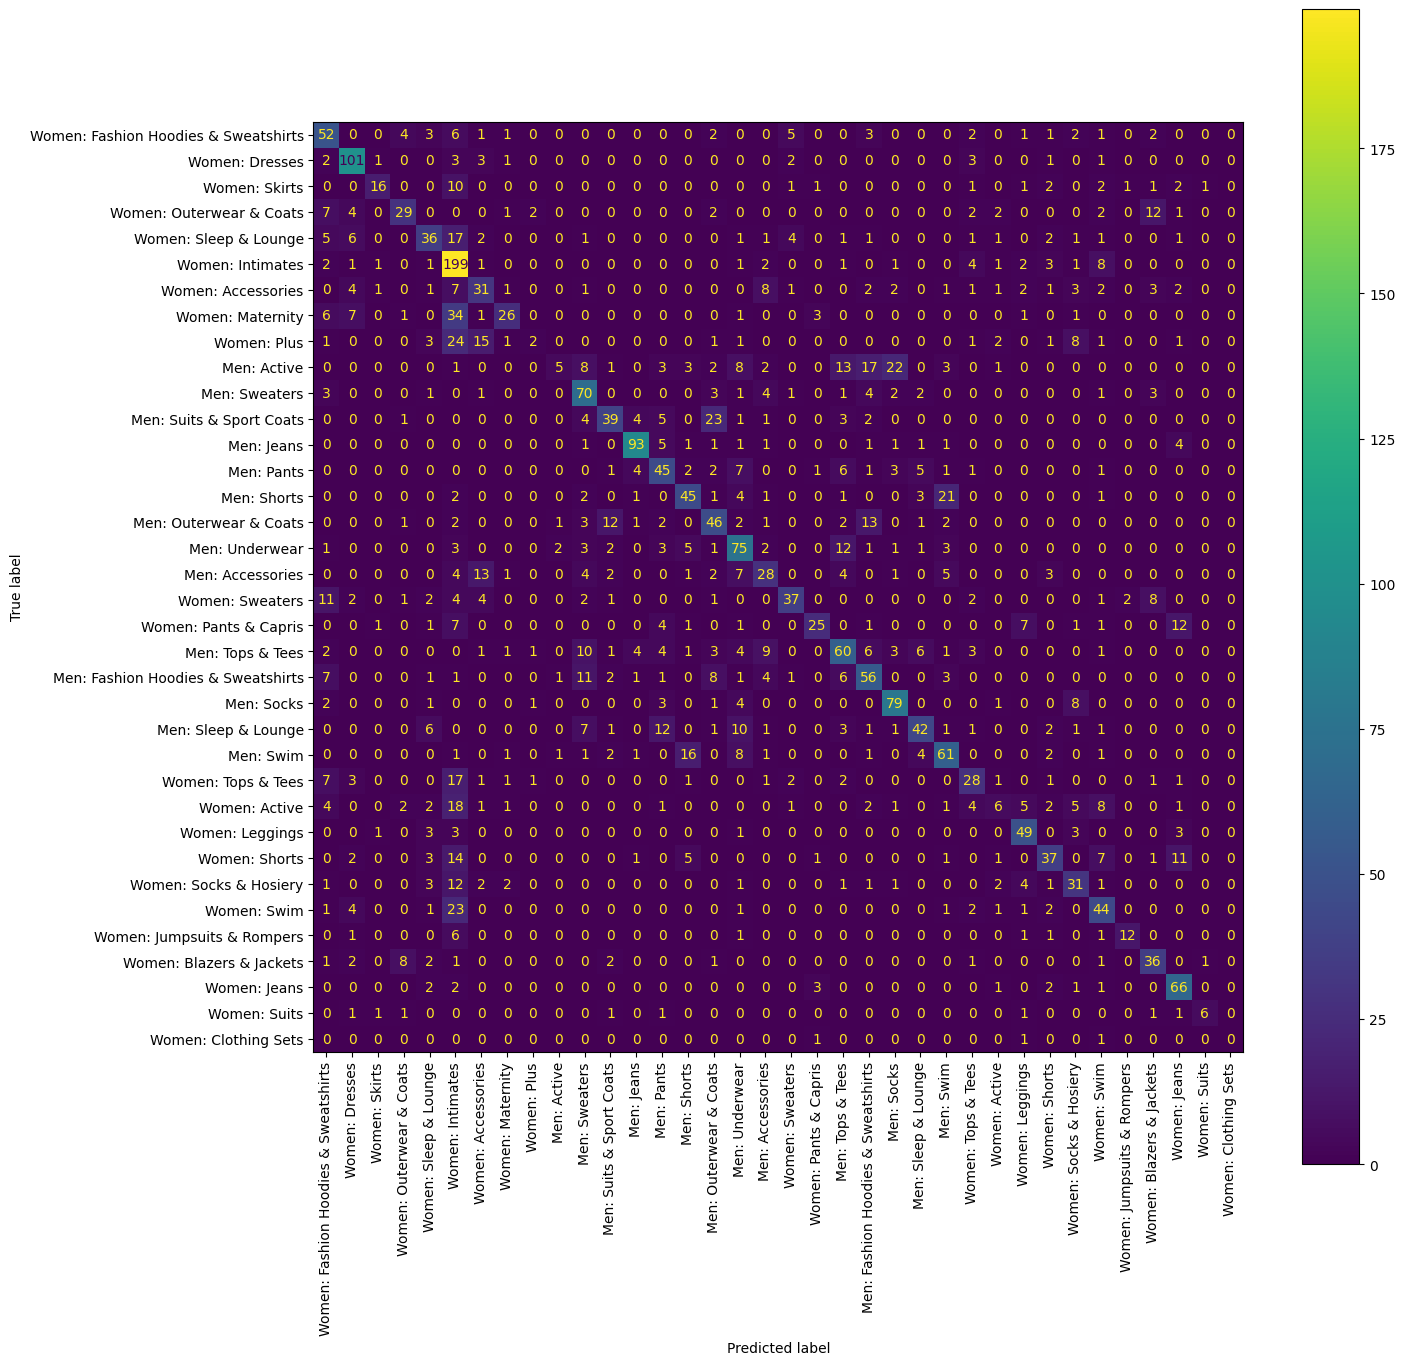

In [223]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [224]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.42      0.37      0.39        75
                         Men: Active       0.50      0.06      0.10        89
  Men: Fashion Hoodies & Sweatshirts       0.50      0.54      0.52       104
                          Men: Jeans       0.85      0.84      0.84       111
              Men: Outerwear & Coats       0.46      0.52      0.48        89
                          Men: Pants       0.51      0.56      0.53        80
                         Men: Shorts       0.56      0.55      0.55        82
                 Men: Sleep & Lounge       0.65      0.46      0.54        91
                          Men: Socks       0.67      0.79      0.72       100
            Men: Suits & Sport Coats       0.58      0.47      0.52        83
                       Men: Sweaters       0.55      0.72      0.62        97
                           Men: Swim       0.58      0.60      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Train Split

In [225]:
train_pred = predictor('classifier', 'train')

In [226]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,11078,714
Women,595,13819


In [227]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.95      0.94      0.94     11792
       Women       0.95      0.96      0.95     14414

    accuracy                           0.95     26206
   macro avg       0.95      0.95      0.95     26206
weighted avg       0.95      0.95      0.95     26206



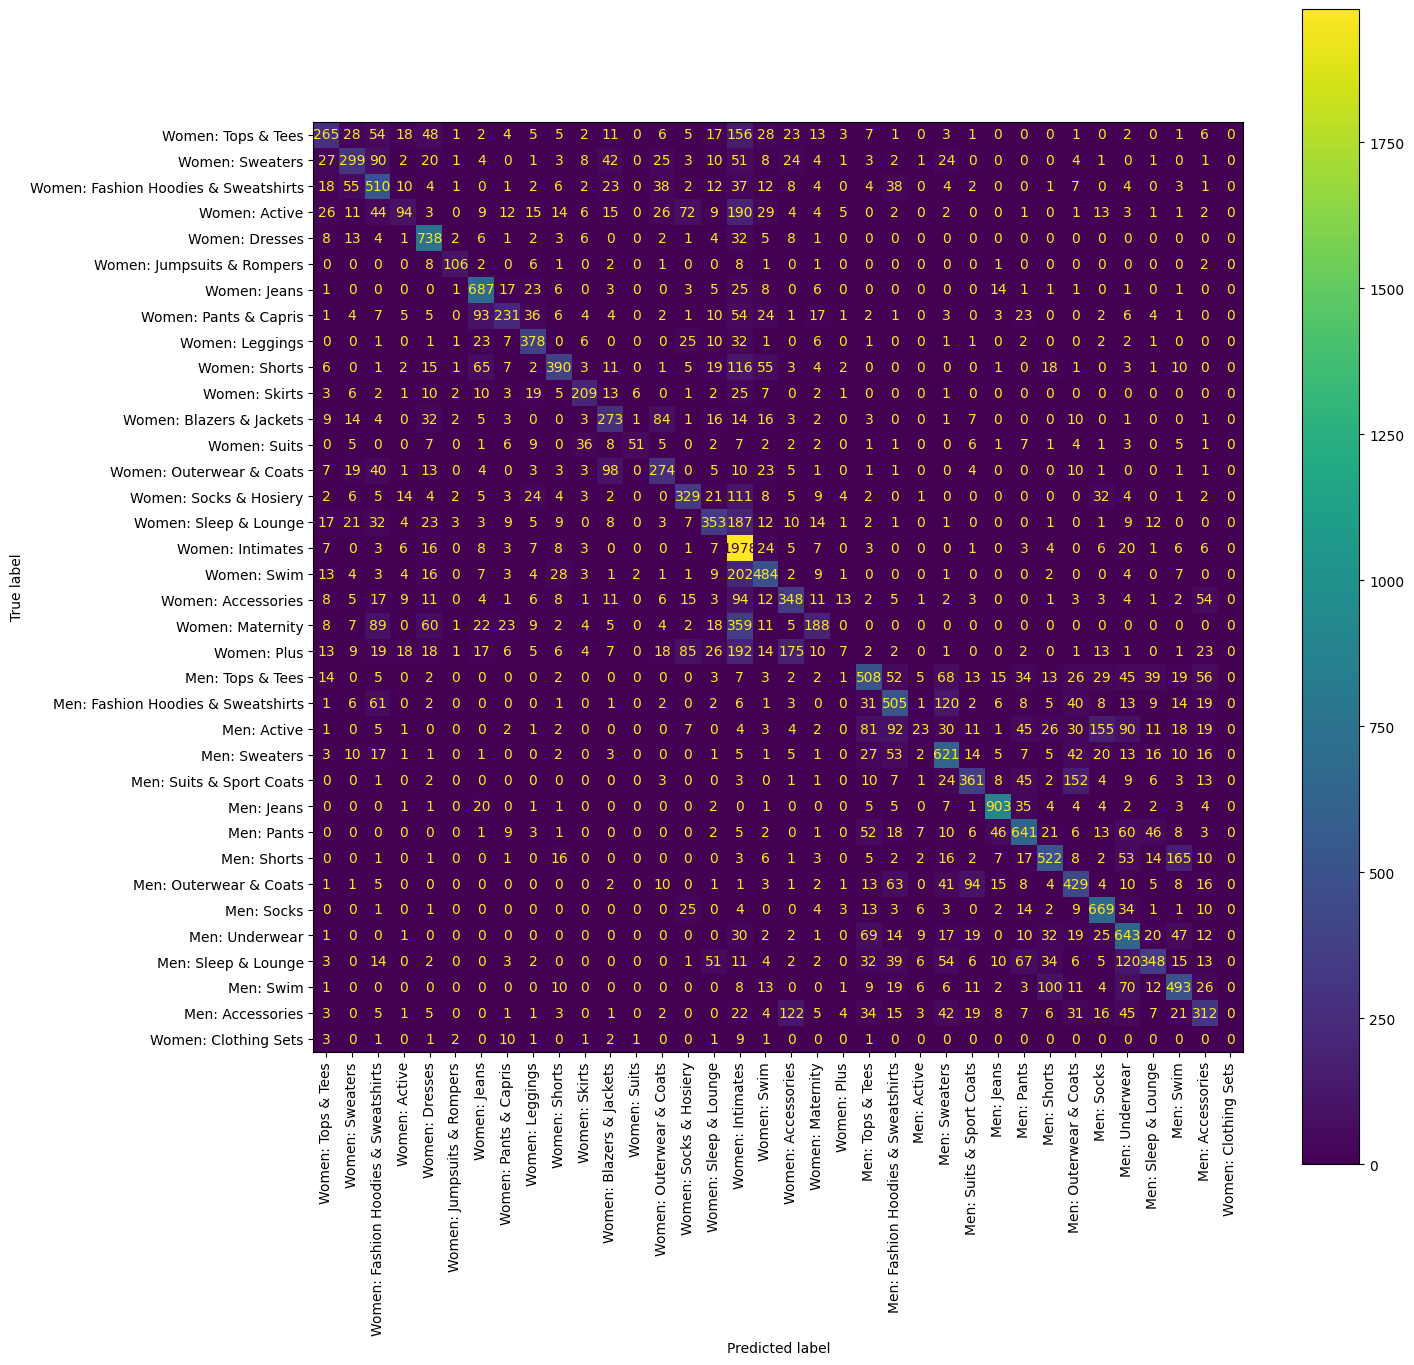

In [228]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [229]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                      precision    recall  f1-score   support

                    Men: Accessories       0.50      0.42      0.45       745
                         Men: Active       0.31      0.03      0.06       664
  Men: Fashion Hoodies & Sweatshirts       0.54      0.58      0.56       867
                          Men: Jeans       0.86      0.90      0.88      1006
              Men: Outerwear & Coats       0.50      0.58      0.54       738
                          Men: Pants       0.65      0.67      0.66       961
                         Men: Shorts       0.65      0.61      0.63       857
                 Men: Sleep & Lounge       0.62      0.41      0.49       850
                          Men: Socks       0.65      0.83      0.73       805
            Men: Suits & Sport Coats       0.62      0.55      0.58       656
                       Men: Sweaters       0.56      0.69      0.62       902
                           Men: Swim       0.57      0.61      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model Serving: Classifier For Absolute Difference Between Embeddings

#### Test Split

In [179]:
test_pred = predictor('classifier_adiff', 'test')

In [180]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,585,Three Dots Red Women's Scoop Neck Top,Women: Tops & Tees,Women,Women,0.800322,Women: Fashion Hoodies & Sweatshirts,0.086903
1,847,Patty Women Russian Faux Fur Trim Hooded Jumpe...,Women: Sweaters,Women,Women,0.689426,Women: Blazers & Jackets,0.178083
2,959,Sucette Rose Faux Mongolian Fur Vest in Black ...,Women: Sweaters,Women,Women,0.918187,Women: Sweaters,0.092496
3,6544,Cloudveil Women's Rio Short,Women: Shorts,Women,Women,0.479144,Women: Shorts,0.531715
4,7772,Allegra K Ladies Tiered Flouncing Lapel Button...,Women: Blazers & Jackets,Women,Women,0.923728,Women: Blazers & Jackets,0.239686


In [181]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1215,123
Women,104,1470


In [218]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.92      0.91      0.91      1338
       Women       0.92      0.93      0.93      1574

    accuracy                           0.92      2912
   macro avg       0.92      0.92      0.92      2912
weighted avg       0.92      0.92      0.92      2912



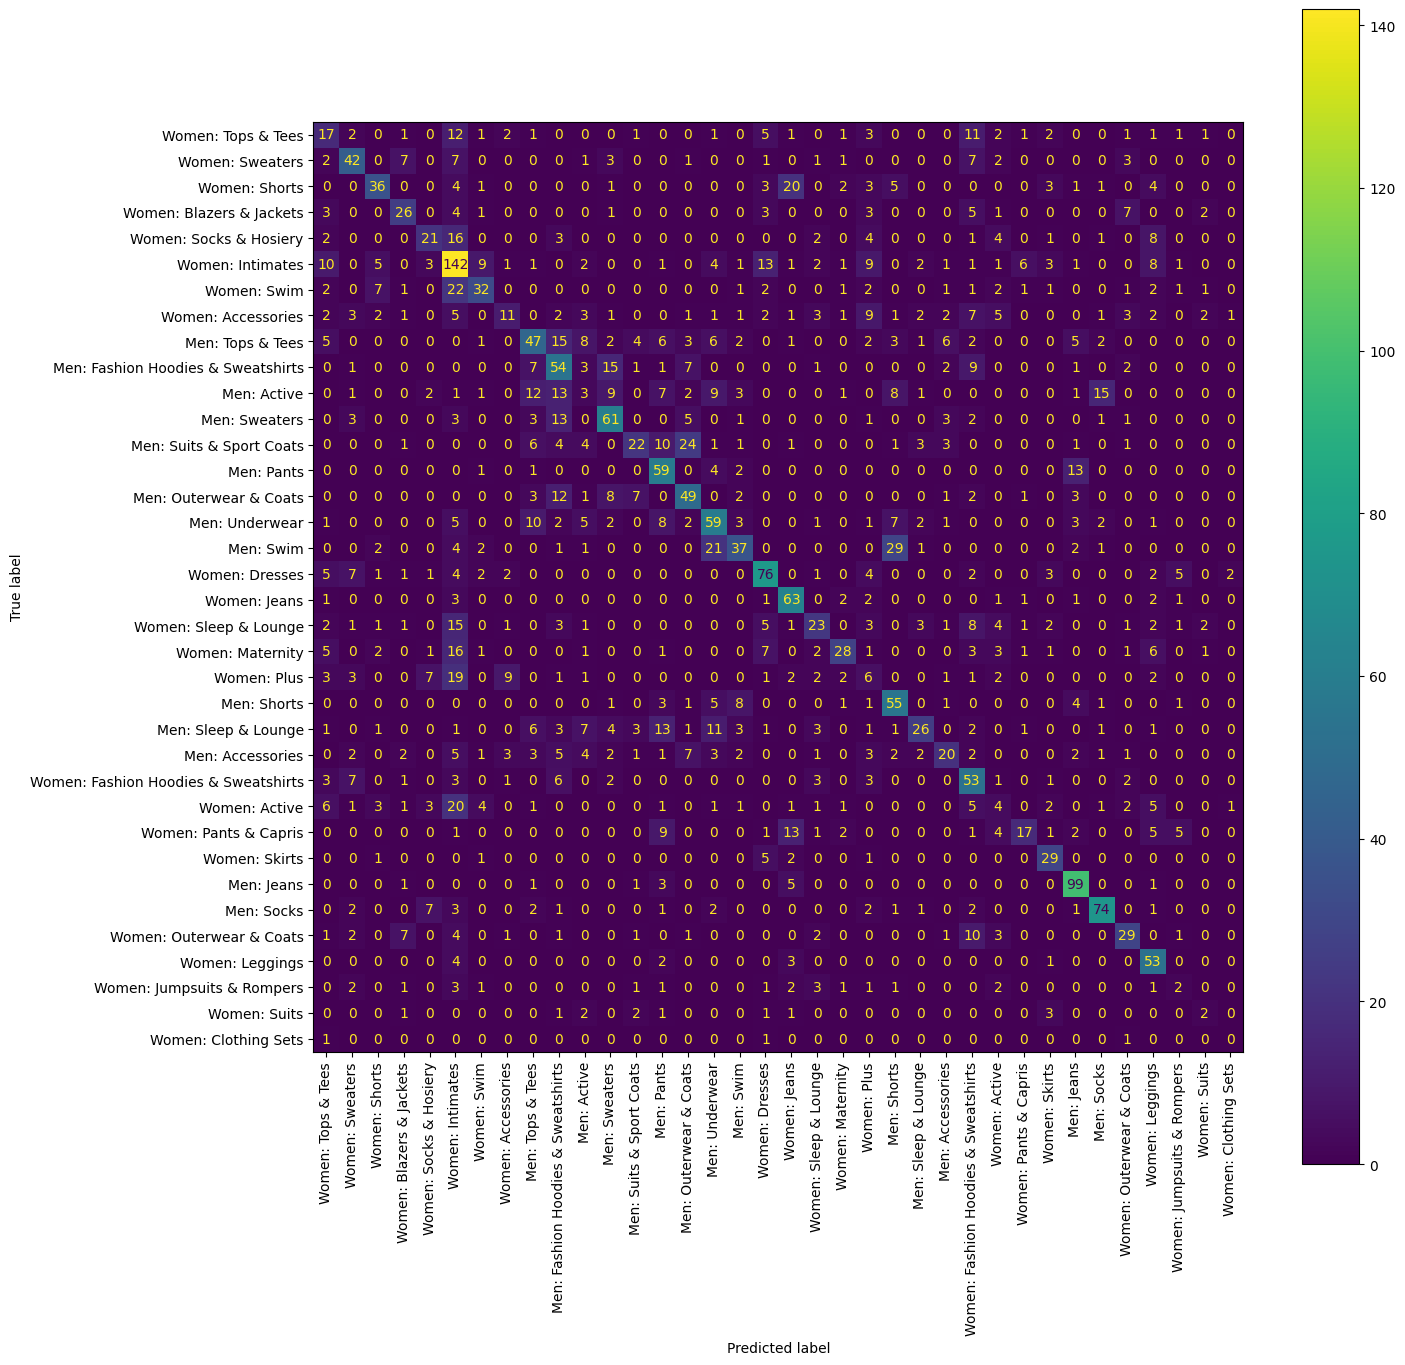

In [215]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [216]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.45      0.27      0.34        75
                         Men: Active       0.06      0.03      0.04        89
  Men: Fashion Hoodies & Sweatshirts       0.39      0.52      0.44       104
                          Men: Jeans       0.71      0.89      0.79       111
              Men: Outerwear & Coats       0.47      0.55      0.51        89
                          Men: Pants       0.46      0.74      0.57        80
                         Men: Shorts       0.48      0.67      0.56        82
                 Men: Sleep & Lounge       0.59      0.29      0.39        91
                          Men: Socks       0.73      0.74      0.73       100
            Men: Suits & Sport Coats       0.50      0.27      0.35        83
                       Men: Sweaters       0.54      0.63      0.58        97
                           Men: Swim       0.54      0.37      

#### Train Split

In [183]:
train_pred = predictor('classifier_adiff', 'train')

In [184]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,10856,936
Women,749,13665


In [217]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.94      0.92      0.93     11792
       Women       0.94      0.95      0.94     14414

    accuracy                           0.94     26206
   macro avg       0.94      0.93      0.93     26206
weighted avg       0.94      0.94      0.94     26206



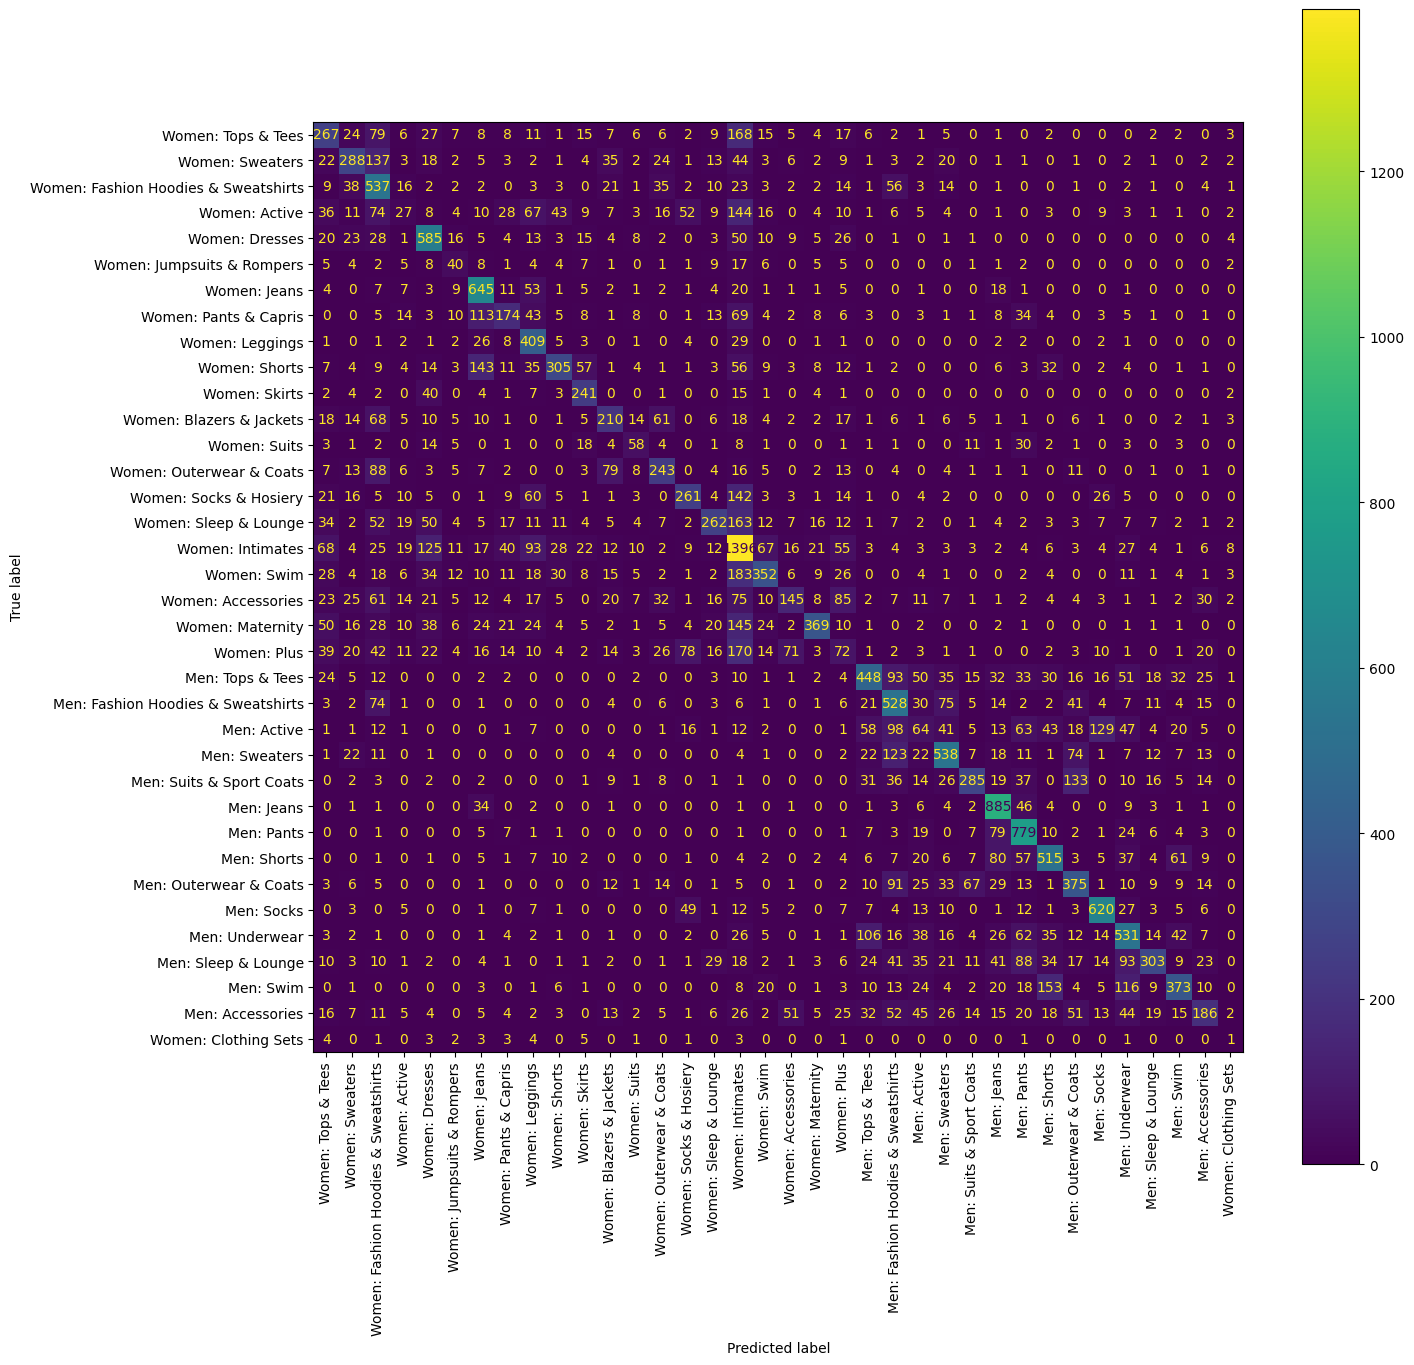

In [213]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [214]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.47      0.25      0.33       745
                         Men: Active       0.14      0.10      0.11       664
  Men: Fashion Hoodies & Sweatshirts       0.44      0.61      0.51       867
                          Men: Jeans       0.67      0.88      0.76      1006
              Men: Outerwear & Coats       0.48      0.51      0.49       738
                          Men: Pants       0.59      0.81      0.68       961
                         Men: Shorts       0.57      0.60      0.58       857
                 Men: Sleep & Lounge       0.67      0.36      0.47       850
                          Men: Socks       0.70      0.77      0.73       805
            Men: Suits & Sport Coats       0.62      0.43      0.51       656
                       Men: Sweaters       0.60      0.60      0.60       902
                           Men: Swim       0.61      0.46      

### Model Serving: Classifier For Concatenated Embeddings AND Absolute Difference Between Embeddings

#### Test Split

In [264]:
test_pred = predictor('classifier_conadiff', 'test')

In [265]:
test_pred.head()

,id,name,category,department,pred_department,pred_department_prob,pred_category,pred_category_prob
0,744,Allegra K Women Single Breasted V Neck Short S...,Women: Tops & Tees,Women,Women,0.999707,Women: Tops & Tees,0.429643
1,4428,Lucky Brand Women's Wescoat Sweet N Low Five-P...,Women: Jeans,Women,Women,0.997671,Women: Jeans,0.487546
2,7365,Billabong Show Me Mini Skirt - Women's,Women: Skirts,Women,Women,0.999863,Women: Skirts,0.621780
3,9223,Tubular Frog Non-Skid Slipper Socks by K. Bell,Women: Socks & Hosiery,Women,Women,0.159628,Women: Socks & Hosiery,0.231972
4,9478,Flames Design Fishnet Pantyhose Queen Plus Size,Women: Socks & Hosiery,Women,Women,0.953320,Women: Socks & Hosiery,0.046408


In [266]:
test_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,1266,72
Women,52,1522


In [267]:
print(
    metrics.classification_report(
        list(test_pred['department']),
        list(test_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       0.96      0.95      0.95      1338
       Women       0.95      0.97      0.96      1574

    accuracy                           0.96      2912
   macro avg       0.96      0.96      0.96      2912
weighted avg       0.96      0.96      0.96      2912



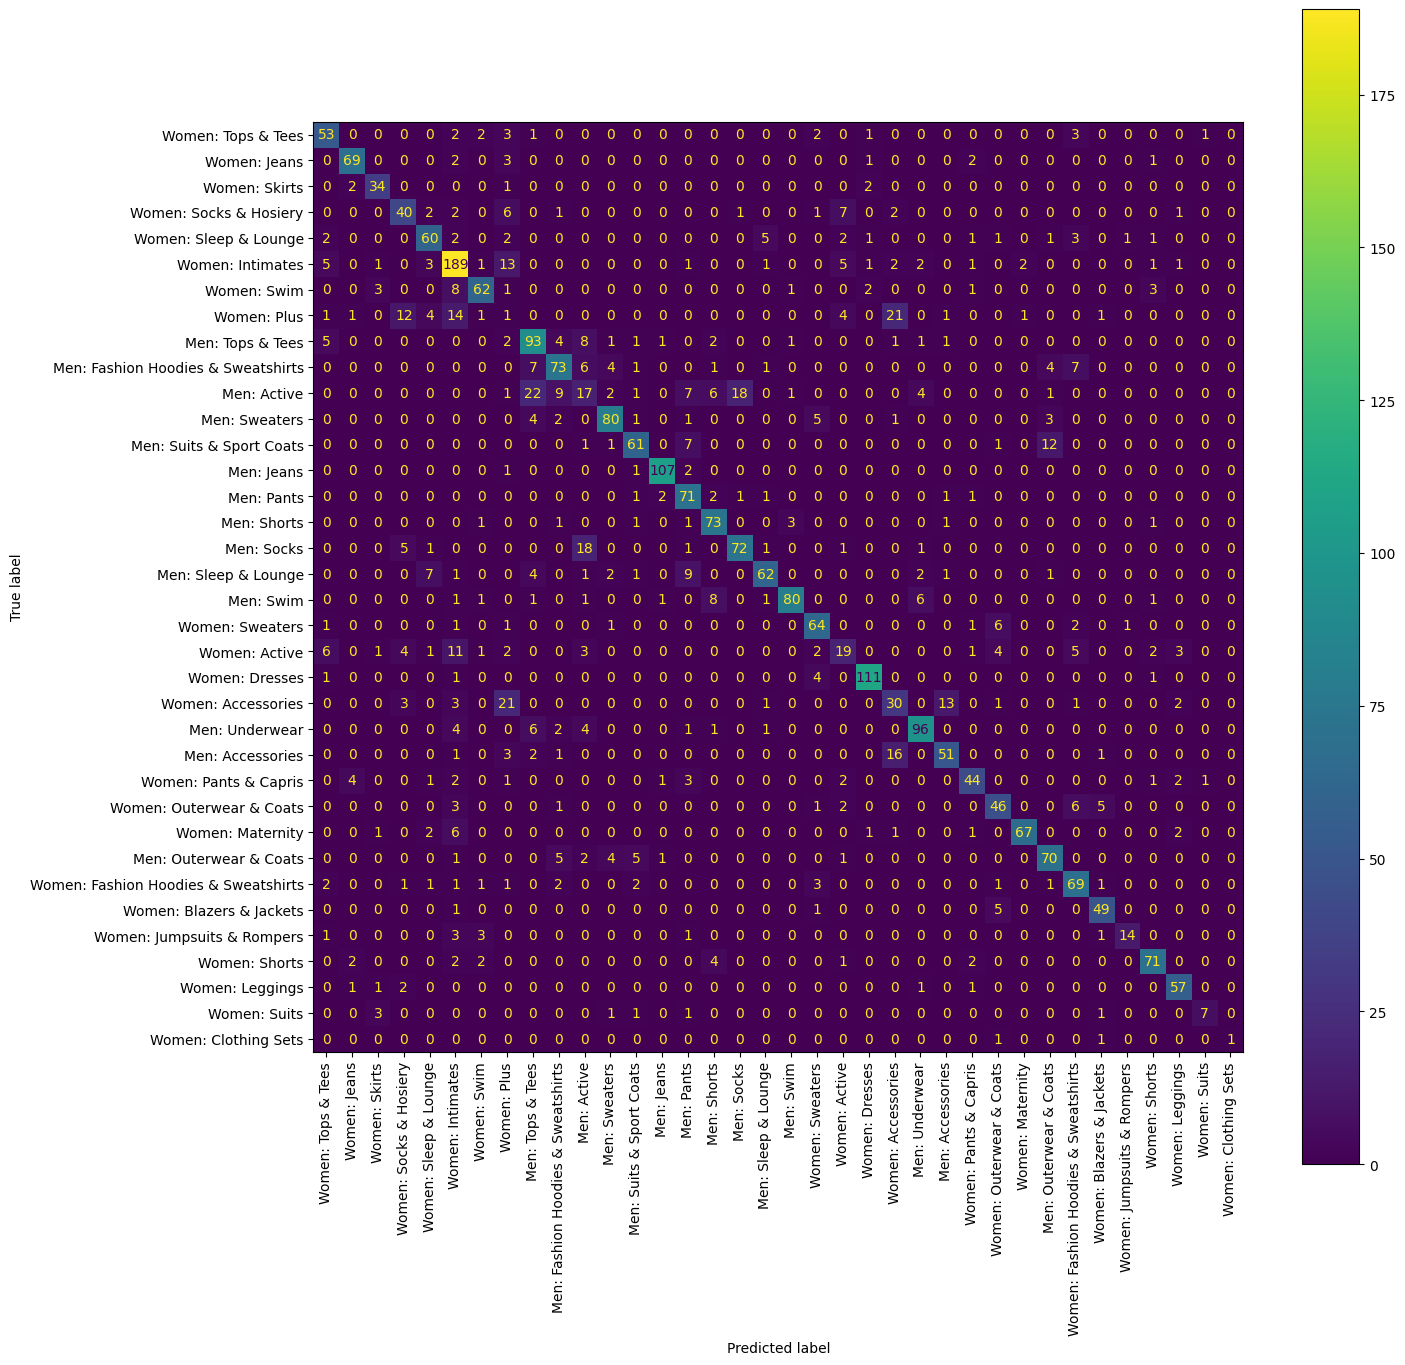

In [268]:
labels = list(test_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(test_pred['category']),
        list(test_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [269]:
print(
    metrics.classification_report(
        list(test_pred['category']),
        list(test_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.74      0.68      0.71        75
                         Men: Active       0.28      0.19      0.23        89
  Men: Fashion Hoodies & Sweatshirts       0.72      0.70      0.71       104
                          Men: Jeans       0.95      0.96      0.96       111
              Men: Outerwear & Coats       0.75      0.79      0.77        89
                          Men: Pants       0.67      0.89      0.76        80
                         Men: Shorts       0.75      0.89      0.82        82
                 Men: Sleep & Lounge       0.84      0.68      0.75        91
                          Men: Socks       0.78      0.72      0.75       100
            Men: Suits & Sport Coats       0.79      0.73      0.76        83
                       Men: Sweaters       0.83      0.82      0.83        97
                           Men: Swim       0.93      0.79      

#### Train Split

In [270]:
train_pred = predictor('classifier_conadiff', 'train')

In [271]:
train_pred.groupby(['department', 'pred_department']).size().unstack(fill_value = 0)

pred_department,Men,Women
department,,
Men,11702,90
Women,30,14384


In [272]:
print(
    metrics.classification_report(
        list(train_pred['department']),
        list(train_pred['pred_department'])
    )
)

              precision    recall  f1-score   support

         Men       1.00      0.99      0.99     11792
       Women       0.99      1.00      1.00     14414

    accuracy                           1.00     26206
   macro avg       1.00      1.00      1.00     26206
weighted avg       1.00      1.00      1.00     26206



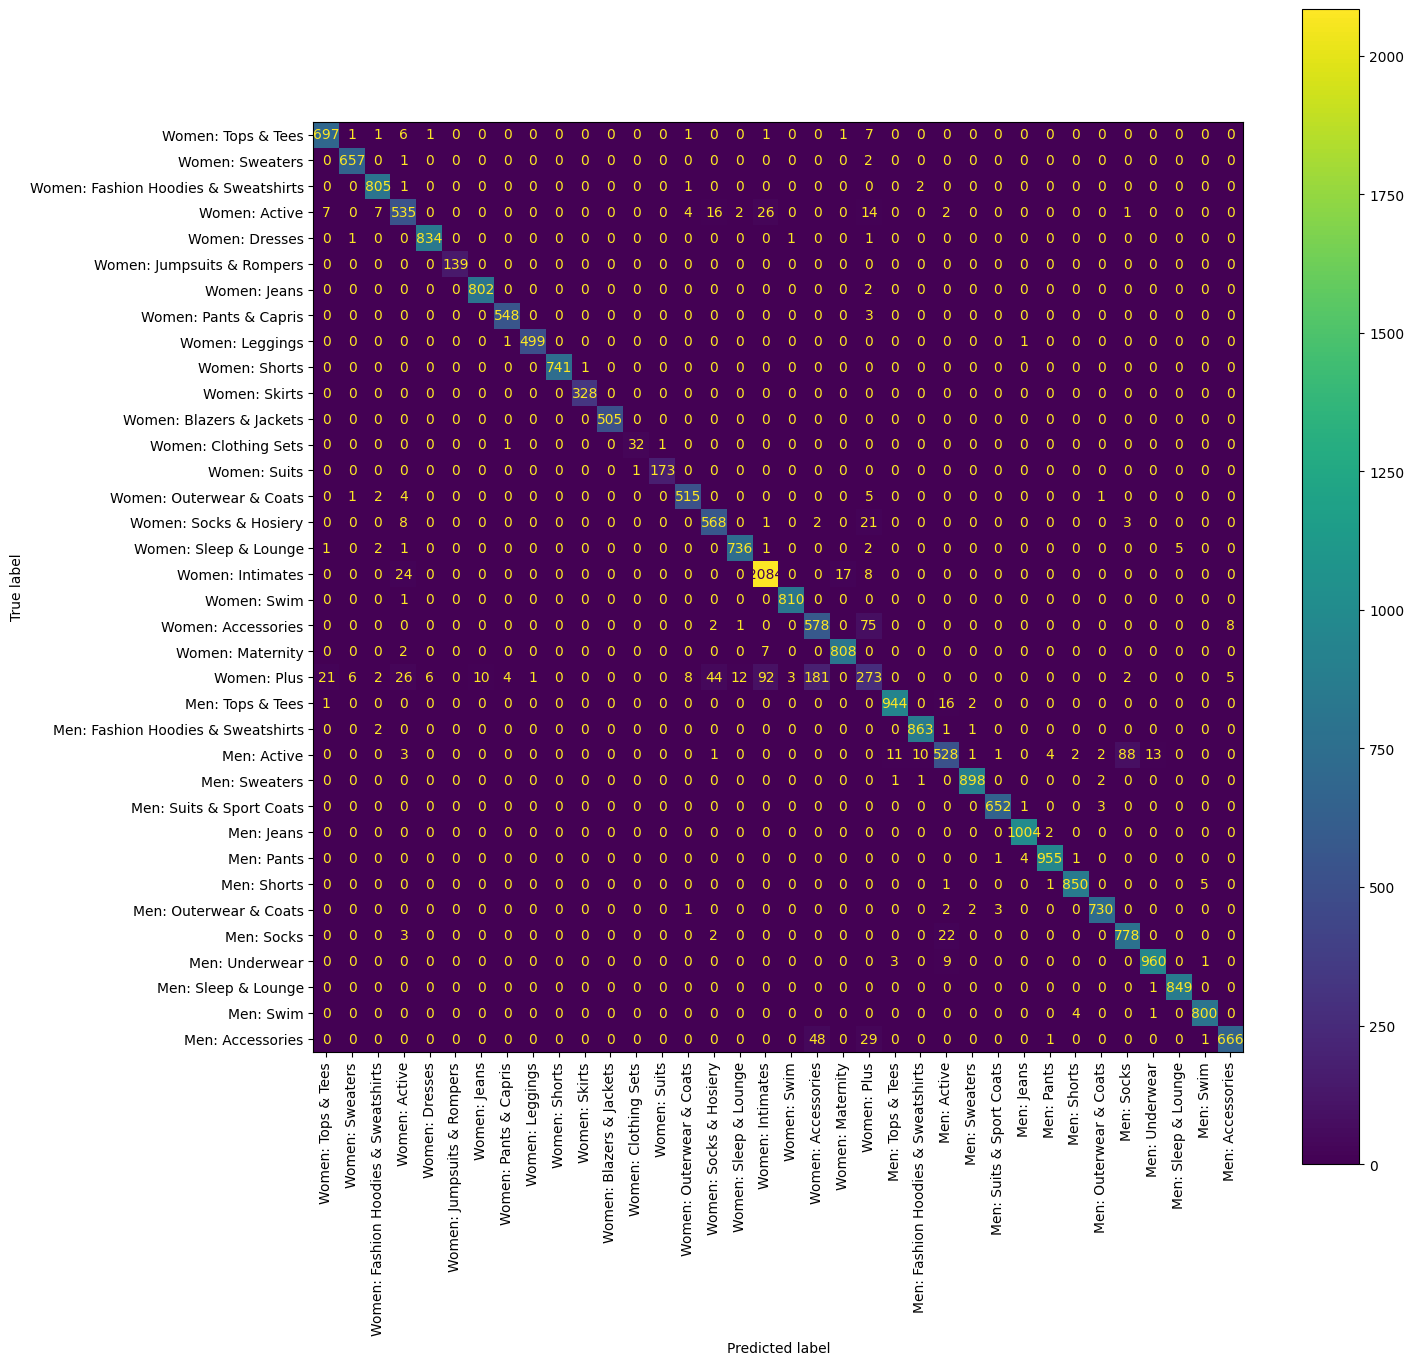

In [273]:
labels = list(train_pred['category'].unique())
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix = metrics.confusion_matrix(
        list(train_pred['category']),
        list(train_pred['pred_category']),
        labels = labels
    ),
    display_labels = labels
)
fig, ax = plt.subplots(figsize = (15,15))
disp.plot(ax = ax, xticks_rotation = "vertical")

In [274]:
print(
    metrics.classification_report(
        list(train_pred['category']),
        list(train_pred['pred_category'])
    )
)

                                      precision    recall  f1-score   support

                    Men: Accessories       0.98      0.89      0.94       745
                         Men: Active       0.91      0.80      0.85       664
  Men: Fashion Hoodies & Sweatshirts       0.99      1.00      0.99       867
                          Men: Jeans       0.99      1.00      1.00      1006
              Men: Outerwear & Coats       0.99      0.99      0.99       738
                          Men: Pants       0.99      0.99      0.99       961
                         Men: Shorts       0.99      0.99      0.99       857
                 Men: Sleep & Lounge       0.99      1.00      1.00       850
                          Men: Socks       0.89      0.97      0.93       805
            Men: Suits & Sport Coats       0.99      0.99      0.99       656
                       Men: Sweaters       0.99      1.00      0.99       902
                           Men: Swim       0.99      0.99      

## Thoughts On Next Steps

The workflow shows that building a product placement preditors is feasible.  The next step would be iterating on model development to increase accuracy.  If product images were available the using multi-modal embeddings would likely be a big boost in accuracy here.

---
## Remove Resources

In [151]:
#bq_connection.ConnectionServiceClient().delete_connection(name = f"projects/{BQ_PROJECT}/locations/{BQ_REGION}/connections/{SERIES}_{EXPERIMENT}")